## Generate Models

This code generates the models for a rectangular wing with a FWTD, it creates a series of models to test different non-linearaties

In [59]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()



In [60]:
sm = mf.SymbolicModel.from_file('3B3T-M5.py')

In [61]:
p = rw.base_params(7)

#set fixed values
p.rho.value = 1.225
p.s_t.value = 1.345
p.c.value = 0.15
p.EI.value = 61
p.GJ.value = 200
p.rho_t.value = 10
p.e_0.value = 0
p.e_1.value = 0
p.ratio_fwt.value = 0.2
p.alpha_s.value = np.deg2rad(15)
p.eta.value = [1]*p.qs

variables = [p.V,p.alpha_r,p.c_dmax,p.m_factor,p.Lambda]

sm_mini = sm.msubs(p.GetSubs(0,[0]*p.qs*2,ignore = variables))
nm = sm_mini.CreateNumericModel(p)

In [64]:
[i.value for i in variables]

In [86]:
p.V.value = 10
p.alpha_r.value = np.deg2rad(5)
p.c_dmax.value = 1
p.m_factor.value = 1
p.Lambda.value = np.deg2rad(25)

In [87]:
f = me.msubs((sm_mini.f-sm_mini.ExtForces.Q()),{i:0 for i in p.qd})
func_obj = sym.lambdify((p.q,variables),f,"numpy")
guess=[0]*p.qs
values = [i.value for i in variables]
q = fsolve(lambda q: func_obj(q,values)[:,0],guess,factor = 1)    
q

array([-7.33752744e-02,  3.67754348e-02, -6.52717726e-03,  2.95745426e-03,
       -1.37428172e-03,  6.31735092e-17,  1.19063410e+00])

In [90]:
%%time
#generate the numerical model
#nm = sm_mini.CreateNumericModel(p)

def objectiveDeriv(t,y):
    return nm.deriv(t,y,p.GetNumericTuple(y,t))

x0 = [0]*p.qs*2
#x0[::2]=q
#x0[-2] = 1.57
yData = solve_ivp(objectiveDeriv,(0,2),x0)

CPU times: user 7.23 s, sys: 22.1 ms, total: 7.26 s
Wall time: 7.25 s


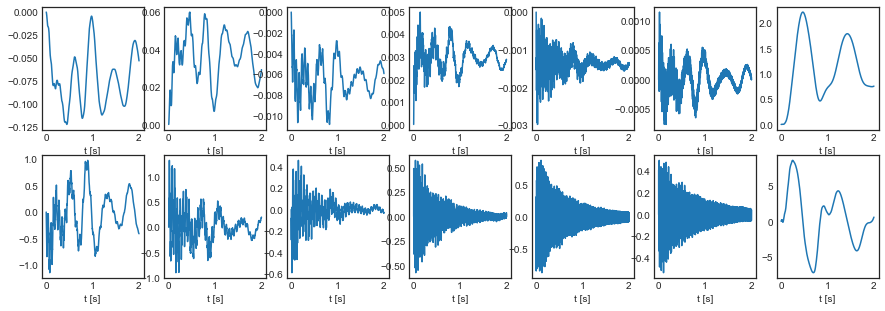

In [91]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

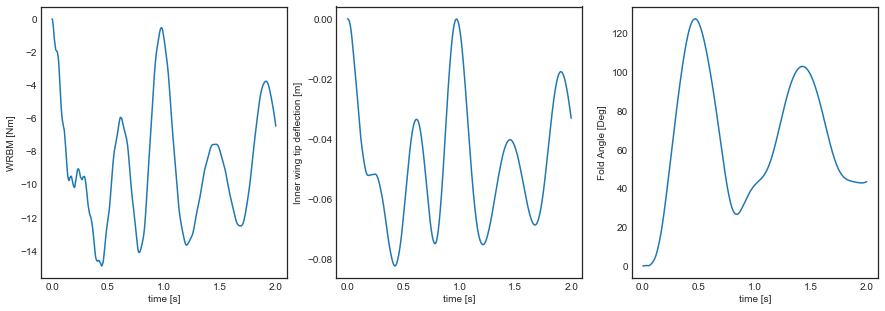

In [117]:
yi = yData.y
t = yData.t

b_shapes = 3
z,_ = mf.ShapeFunctions_BN_TM(b_shapes,0,p.q[:b_shapes],p.y_0,0,0,0,p.eta[:b_shapes])
d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
z_tip = z.subs(p.y_0,p.s_0)

d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)

plt.style.use('seaborn-white')

tup = p.GetNumericTuple([0]*p.qs*2,0)

fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(t,d2z_dy2_f(tup,yi[::2])*p.EI.value)
axes[0].set_ylabel('WRBM [Nm]')
axes[0].set_xlabel('time [s]')

axes[1].plot(t,z_tip_f(tup,yi[::2]))
axes[1].set_ylabel('Inner wing tip deflection [m]')
axes[1].set_xlabel('time [s]')

axes[2].plot(t,np.rad2deg(yi[-2]))
axes[2].set_ylabel('Fold Angle [Deg]')
axes[2].set_xlabel('time [s]')

yi[::2].shape

In [33]:
%%time
sm = mf.SymbolicModel.from_file('3B3T-M1.py')
p = rw.base_params(7)
sm.linearise(p)

CPU times: user 10.8 s, sys: 49.8 ms, total: 10.9 s
Wall time: 10.9 s
